<a href="https://colab.research.google.com/github/janchilling/Glaucoma_Detection/blob/main/Glaucoma_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"keshanpathirana","key":"4eb543880604d03ef1bad51dde835e7b"}'}

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
!kaggle datasets download -d deathtrooper/multichannel-glaucoma-benchmark-dataset

100% 2.92G/2.93G [00:36<00:00, 108MB/s] 
100% 2.93G/2.93G [00:36<00:00, 85.4MB/s]


In [4]:
!unzip -qq multichannel-glaucoma-benchmark-dataset.zip

In [5]:
import pandas as pd

dataframe = pd.read_csv("/content/metadata - standardized.csv")
dataframe.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
positive_count = sum([i for i in dataframe["types"] == 1])
negative_count = sum([i for i in dataframe["types"] == 0])
suspect_count = sum([i for i in dataframe["types"] == -1])

print(f"Number of Glaucoma positive cases in the dataset = {positive_count}")
print(f"Number if Glaucoma negative cases in the dataset = {negative_count}")
print(f"Number of Glaucoma suspect cases in the dataset = {suspect_count}")

Number of Glaucoma positive cases in the dataset = 4767
Number if Glaucoma negative cases in the dataset = 7549
Number of Glaucoma suspect cases in the dataset = 133


In [7]:
import pathlib

original_fundus_dir = pathlib.Path("full-fundus/full-fundus")

In [8]:
orginal_dir_all_images = len([images for images in original_fundus_dir.glob("*")])
orginal_dir_all_images

12449

In [9]:
import os

image_path = os.path.join(original_fundus_dir, "OIA-ODIR-TEST-OFFLINE-1.png")

if os.path.exists(image_path):
    print(f"Image exists")
else:
    print(f"Image does not exist")

Image exists


In [10]:
import shutil

categorized_dir_neg = pathlib.Path("Fundus/Negative")
categorized_dir_pos = pathlib.Path("Fundus/Positive")

os.makedirs(categorized_dir_neg, exist_ok = True)
os.makedirs(categorized_dir_pos, exist_ok = True)

for index, row in dataframe.iterrows():
  src_path = "full-fundus" + row["fundus"]

  if row["types"] == 0:
    dst_path = categorized_dir_neg / pathlib.Path(row["fundus"]).name
  elif row["types"] == 1:
     dst_path = categorized_dir_pos / pathlib.Path(row["fundus"]).name

  shutil.copyfile(src=src_path, dst=dst_path)

In [11]:
print(f"Negative count : {len([images for images in categorized_dir_neg.glob('*')])}")
print(f"Positive count : {len([images for images in categorized_dir_pos.glob('*')])}")

Negative count : 7549
Positive count : 4767


In [12]:
# 2500 test, 1000 val, 1000 test

cat_dir = pathlib.Path("Fundus")
new_base_dir = pathlib.Path("Glaucoma_Fundus_Small")

def makeSubset(subset_name, start_index, end_index):
    for category in ("Negative", "Positive"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        src_filenames = [filename for filename in os.listdir(cat_dir / category) if filename.endswith(".png")]
        for index, src_filenames in enumerate(src_filenames[start_index : end_index]):
          dst_filename = f"{category}.{index}.png"
          src_path = cat_dir / category / src_filenames
          dst_path = dir / dst_filename
          shutil.copyfile(src=src_path, dst=dst_path)

makeSubset("train", start_index=0, end_index=2500)
makeSubset("validation", start_index=2500, end_index=3500)
makeSubset("test", start_index=3500, end_index=4500)

In [13]:
print(f"Test folder Negative count: {len(list((new_base_dir / 'test' / 'Negative').glob('*')))}")
print(f"Test folder Positive count: {len(list((new_base_dir / 'test' / 'Positive').glob('*')))}")

print(f"Train folder Negative count: {len(list((new_base_dir / 'train' / 'Negative').glob('*')))}")
print(f"Train folder Positive count: {len(list((new_base_dir / 'train' / 'Positive').glob('*')))}")

print(f"Validation folder Negative count: {len(list((new_base_dir / 'validation' / 'Negative').glob('*')))}")
print(f"Validation folder Positive count: {len(list((new_base_dir / 'validation' / 'Positive').glob('*')))}")

Test folder Negative count: 1000
Test folder Positive count: 1000
Train folder Negative count: 2500
Train folder Positive count: 2500
Validation folder Negative count: 1000
Validation folder Positive count: 1000


In [14]:
import tensorflow
from tensorflow.keras import layers
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
 weights="imagenet",
 include_top=False)
conv_base.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [15]:
data_augmentation = keras.Sequential([
 layers.RandomFlip("horizontal"),
 layers.RandomRotation(0.1),
 layers.RandomZoom(0.2),
 ])

In [16]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
# inputs = keras.Input(shape=(180, 180, 3))
# x = data_augmentation(inputs)
# x = keras.applications.vgg16.preprocess_input(x)
# x = conv_base(x)
# x = layers.Flatten()(x)
# x = layers.Dense(256)(x)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

In [18]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [24]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
 new_base_dir / "train",
 image_size=(180, 180),
 batch_size=50)

validation_dataset = image_dataset_from_directory(
 new_base_dir / "validation",
 image_size=(180, 180),
 batch_size=50)

test_dataset = image_dataset_from_directory(
 new_base_dir / "test",
 image_size=(180, 180),
 batch_size=50)

Found 5000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [25]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="feature_extraction_with_data_augmentation.keras",
 save_best_only=True,
 monitor="val_loss")
]

In [26]:
history = model.fit(
 train_dataset,
 epochs=60,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/60
100/100 [==============================] - 36s 346ms/step - loss: 0.4143 - accuracy: 0.8060 - val_loss: 0.4414 - val_accuracy: 0.7820
Epoch 2/60
100/100 [==============================] - 36s 342ms/step - loss: 0.4033 - accuracy: 0.8114 - val_loss: 0.4509 - val_accuracy: 0.7910
Epoch 3/60
100/100 [==============================] - 35s 333ms/step - loss: 0.4070 - accuracy: 0.8056 - val_loss: 0.3945 - val_accuracy: 0.8150
Epoch 4/60
100/100 [==============================] - 35s 328ms/step - loss: 0.3951 - accuracy: 0.8146 - val_loss: 0.4249 - val_accuracy: 0.8005
Epoch 5/60
100/100 [==============================] - 35s 334ms/step - loss: 0.4041 - accuracy: 0.8098 - val_loss: 0.4087 - val_accuracy: 0.8050
Epoch 6/60
100/100 [==============================] - 36s 342ms/step - loss: 0.3883 - accuracy: 0.8154 - val_loss: 0.5002 - val_accuracy: 0.7660
Epoch 7/60
100/100 [==============================] - 34s 321ms/step - loss: 0.3862 - accuracy: 0.8194 - val_loss: 0.4992 - val_ac

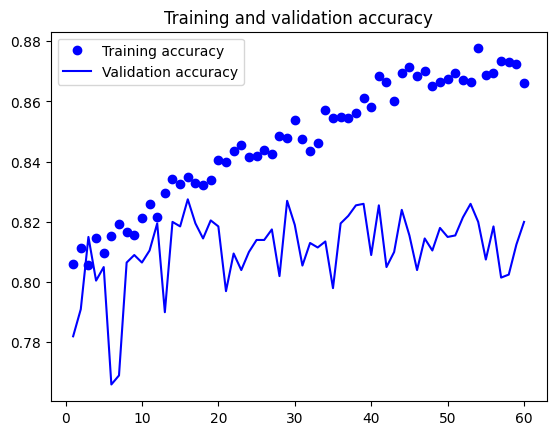

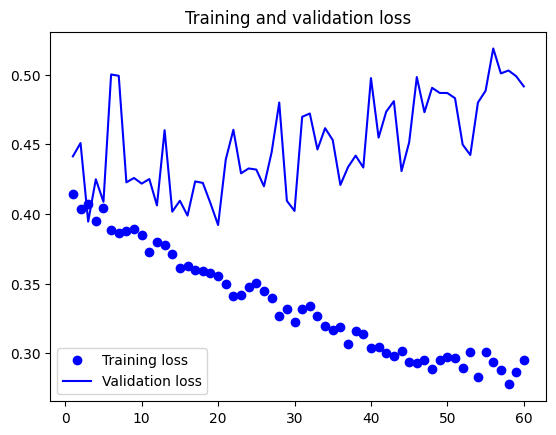

In [27]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [28]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

40/40 [==============================] - 9s 170ms/step - loss: 0.4491 - accuracy: 0.8160
Test accuracy: 0.816
